<a href="https://colab.research.google.com/github/aniruddh-pramod/aniruddh-pramod/blob/main/SNN_Assignment_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spiking Neural Networks Assignment**

This is an assignment covering the basics of Spiking Neural Networks. In SNNs, if a neuron’s value surpasses a certain threshold, the neuron will “Spike” and send a single impulse to each downstream neuron connected to the first one. SNNs are resource efficient alternatives to artificial neural networks: able to function with fewer neurons and usually being much faster. They are also dynamic and can train while working, providing an edge in dynamic tasks like speech identification. 

We will start off by simulating a single spiking neuron, and then slowly increase the complexity of our simulation. Then we will introduce synapses and visualize them.

For simulations, we will be using the brian2 python library. 

In [1]:
!pip install brian2
!pip install --upgrade numpy

     |████████████████████████████████| 1.5 MB 5.4 MB/s 
     |████████████████████████████████| 15.7 MB 17.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
# Run this cell to import the necessary libraries.
import brian2
from brian2 import *
%matplotlib inline

### **Simulation of a Single Spiking Neuron**

In this section, we will be simulating a simple, single spiking Neuron using brian2. Our neuron will be governed by a basic differential equation given by;

\begin{align*}
\\
&\,\frac{d}{dt}\,V(t) = (1 - V(t))/\tau  
 &\\
\\
\end{align*}
Where V(t) is the voltage of a neuron at any time t. Upon integration, we get that;
\begin{align*}
\\
&V(t) = 1 - exp(-t/\tau)
 &\\
\\
\end{align*}
Clearly, according to the above equation you should see that V(t) starts from 0 and tends towards 1 as time progresses.
To add the spiking feature, we would set a threshold value. 

Your task is to fill in the blanks in the code cell below and run it. You should see a graph of voltage of the neuron vs time.






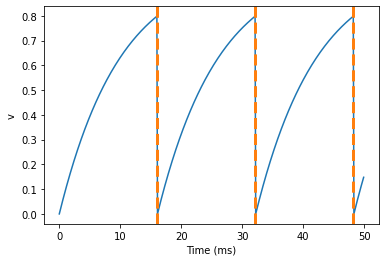

In [5]:
tau = 10*ms
# Fill the differential equation defining the neuron in the blank
eqs = 'dv/dt = (1 - v)/tau : 1'
num_neurons=1

#This is our group of Neurons. We can define various parameters of our simulation here.
#The threshold defines the condition for which the neurons will spike. Try adjusting the values and see how it affects the graph
#The reset attribute defines what happens after a neuron spikes.

G = NeuronGroup(num_neurons, eqs, threshold='v>0.8', reset='v = 0', method='exact')

#The StateMonitor function stores a record of the values of the Neuron during the simulation.
#Record is set to 0 because we want to record the values of the 1st neuron.
statemon = StateMonitor(G, 'v', record=0)

#The SpikeMonitor functions records the times at which the neuron spikes
spikemon = SpikeMonitor(G)

run(50*ms) #Run the simulation for 50 ms.
time_stamps=statemon.t/ms 
voltages=statemon.v[0]


#Now, plot the voltage of the neuron with time, with the spikes marked with a yellow vertical line.
plot(time_stamps,voltages)
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

You are encouraged to play around with the parameter values to see how it affects the graph. Also, try changing the differential equation governing our neuron.

### **Simulation of Multiple Spiking Neurons**

Now, lets add some complexity to our model. We will increase the number of neurons and add a delay to the spikes, with parameters varying for each neuron. This time, our differential equation will be as follows:

\begin{align*}
\\
&\,\frac{d}{dt}\,V(t) = (V_o - V(t))/\tau  
 &\\
\\
\end{align*}
where V_not is a parameter different for each neuron. For the ith neuron, V_not varies as:
\begin{align*}
\\
&\\V_o = i*max(V_o)/(N-1)
 &\\
\\
\end{align*}
where max(V_not) is a predefined constant and N is the number of neurons in our model. 

Fill in the code below to run a simulation for1000ms, involving 100 neurons. Set tau to be 10 milliseconds, and the threshold to be v>1. Make sure that you use the differential equations defined above.




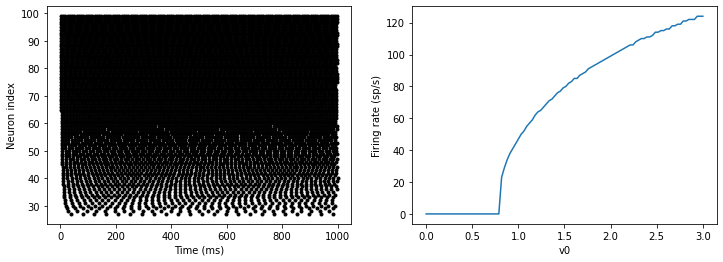

In [6]:
start_scope() 

#Fill in these variables as instructed above.
num_neurons = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

#Fill in the new differential equation governing our Neuron Group
eqs = '''
dv/dt = (v0 - v)/tau: 1 (unless refractory)
v0 : 1
'''

#Fill in the threshold and reset conditions as instructed
#Here we see a new parameter called refractory. This is the delay period after a spike has occured.
G = NeuronGroup(num_neurons, eqs, threshold='v>0.8', reset='v=0', refractory=5*ms, method='exact')
spikemon= SpikeMonitor(G)

#Fill in the formula for the value of V_not for the ith Neuron
G.v0 = 'i*v0_max/(N-1)'

run(duration)

#Plot the graphs
figure(figsize=(12,4))
subplot(121)
plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, spikemon.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

So in this example, we’re driving the neuron towards the value v0 exponentially, but when v crosses v>1, it fires a spike and resets. The effect is that the rate at which it fires spikes will be related to the value of v0. For v0 greater than 1 it will never fire a spike, and as v0 gets larger it will fire spikes at a higher rate. The right hand plot shows the firing rate as a function of the value of v0. This is the I-f curve of this neuron model.



### **Simulation of Three Spiking Neurons with Synapses**

Next, we will be adding synapses to our model of the Spiking Neurons. A synapse is how two neurons communicate. In our model, a spike in one neuron will cause a change in the potential of the other neuron as well. This time, the differential equation that we will use is:
\begin{align*}
\\
&\,\frac{d}{dt}\,V(t) = (I - V(t))/\tau  
 &\\
\\
\end{align*}
Where I is the current through the neuron.
What happens if the current I is 0? The voltage V, becomes negative no matter what. So, a neuron with I=0 would not fire on its own, it can only fire if there is a synapse. 

We want that when a neuron spikes, all the neurons connected to it experience an increment of w in voltage, where w is defined as:
\begin{align*}
\\
&w = j*0.2
 &\\
\\
\end{align*}
for the jth neuron.

Run the code below after filling in the blanks to simulate three spiking neurons connected by synapses.

WARNING    'tau' is an internal variable of group 'neurongroup_2', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


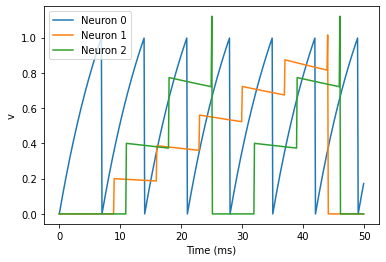

In [7]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau: 1
I : 1
tau : second
'''

num_neurons=3
G = NeuronGroup(num_neurons, eqs, threshold='v>1', reset='v = 0', method='exact')

#Define the I values for each neuron.
G.I = [2, 0, 0]
#Define the Tau values for each neuron.
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w') #This means that the second neuron's voltage increases by w when the first neuron spikes
S.connect(i=0, j=[1, 2])#This creates a synapse from ith Neuron to jth Neurons.
S.w = 'j*0.2'#Fill in the value for w for the jth neuron
S.delay = 'j*2*ms' 

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0') #plot voltage vs time for each neuron
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

### **Simulation of Multiple Spiking Neurons with Synapses**

Finally, we will be simulating multiple spiking neurons connected through synapses.

In [8]:
start_scope()

N = 10 #Number of Neurons
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2) #Define the condition for the ith and jth neurons to be connected, and the probability of it.

In [9]:
#This is a function to help visualize synapses. Run this cell as it is.
def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')



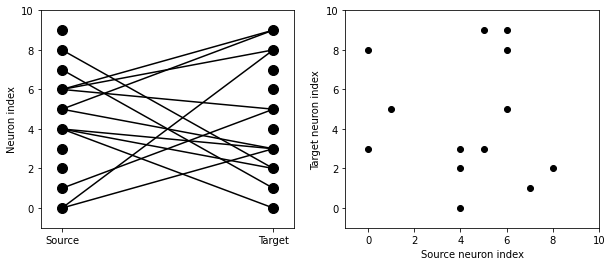

In [10]:
visualise_connectivity(S)

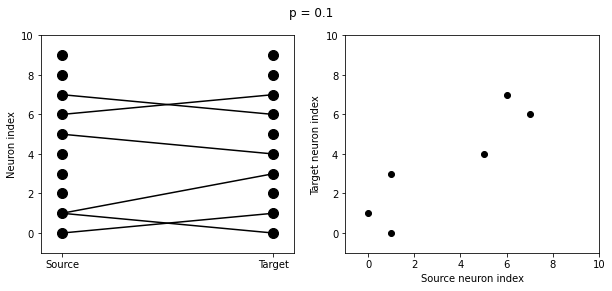

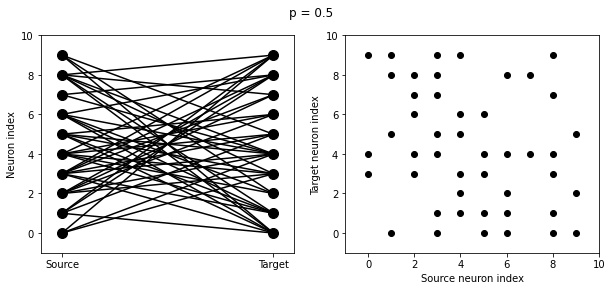

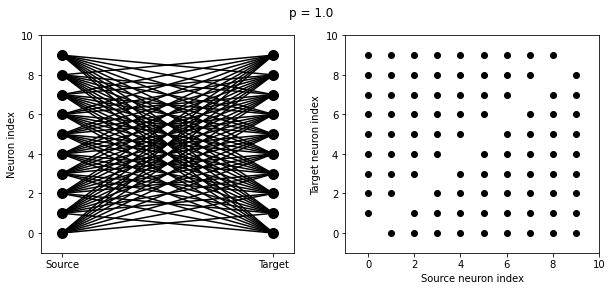

In [11]:
#See how different probabilities can have different effects on the connections between Neurons.
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p));